In [1]:
import os
import sys

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xesmf as xe
import xcdat as xc
import xsearch as xs
import xskillscore as xscore

from glob import glob 
from typing import List, Tuple, Dict, Union, Optional, Any, Callable, Iterable, Sequence, cast

# Ignore xarray warnings (bad practice)
import warnings
warnings.simplefilter("ignore") 

In [2]:
def ingest_and_process(
    output_grid: np.ndarray,
    var: str = "tos", 
    cmipTable: str ="Omon", 
    era: str = "CMIP6",
    testing: bool = False,
    calc_anoms: bool = False
) -> dict:
    """
    Ingests all the data from the CMIP piControl experiment. 
    Optionally remove the seasonal cycle and detrend the data, regrid to a commond 2.5 x 2.5 degree grid and return a new dataset

    Returns:
        xarray datasets with dimensions (model, time, lat, lon)
    """

    # Specify the ensemble member
    if era == "CMIP6": 
        member = "r1i1p1f1"
    else:
        member = "r1i1p1"

    # Find all the paths to the data
    dpaths = xs.findPaths(
        experiment="piControl",
        variable=var,
        frequency="mon",
        cmipTable=cmipTable,
        mip_era=era, 
        activity="CMIP",
        member=member
    )
    models =  xs.getGroupValues(dpaths, 'model')
    dpaths = list(dpaths.keys())
    
    # Create an empty Dataset
    ds = []
    valid_models = []

    for i, (model_path, model) in enumerate(zip(dpaths, models)):
        print("Starting model: ", model)
        print("Model path: ", model_path)

        try:
            # Load data
            da = xc.open_mfdataset(glob(model_path + "/*.nc")) #, parallel=True, chunks="auto")

            # Regrid Data
            output = da.regridder.horizontal(var, output_grid, tool='xesmf', method='bilinear')

            # Deseasonalize (no need to detrend piControl data, there should be no drift)
            if calc_anoms:
                output = output.temporal.departures(var, "month")

            ntime, _, _ = output[var].shape

            nmonths = 150*12
            if ntime < nmonths:
                continue

            output = output[var][:nmonths]
            time = np.arange(np.datetime64("1850-01"), np.datetime64("1850-01") + np.timedelta64(nmonths, 'M'), dtype="datetime64[M]")
            output["time"] = time
            ds.append(output)
            valid_models.append(model)

            # Only load one model if testing
            if testing:
                _, axes = plt.subplots(ncols=2, figsize=(16, 4))
                da[var].isel(time=0).plot(ax=axes[0])
                axes[0].set_title('Input data')
                output.isel(time=0).plot(ax=axes[1])
                axes[1].set_title('Output data')
                plt.tight_layout()

                if i == 1:
                    break
        
        except Exception as e:
            print("Model failed: ", model, e)

    ds = xr.concat(ds, dim='model')
    ds.coords['model'] = list(valid_models)

    return ds


def collect_data():
    """
    Iterate through all the variables and eras and save the data
    """

    # Define Constants
    eras = ["CMIP6"] #, "CMIP5"]
    variables = ["rsutcs", "rsut", "tos"] # tos == sea surface temperature
    calc_anoms = False

    # Create output grid
    lat = np.arange(-88.75, 90, 2.5)
    lon = np.arange(1.25, 360, 2.5)
    output_grid = xc.create_grid(lat, lon)

    for era in eras: 
        print("Starting era: ", era)
        for var in variables:
            print("Starting variable: ", var)

            if var == "tos": 
                table = "Omon"
            else: 
                table = "Amon"

            ds = ingest_and_process(
                var=var,
                cmipTable=table,
                era=era,
                testing=TESTING,
                output_grid=output_grid,
                calc_anoms=False
            )

            print(ds)
            if calc_anoms:
                ds.to_netcdf(f"data/{var}_mon_1850-2100_anoms_{era}_piControl.nc")
                ds.close()
            else: 
                ds.to_netcdf(f"data/{var}_mon_1850-2100_{era}_piControl.nc")
                ds.close()
                

        break


TESTING = False
collect_data()

Starting era:  CMIP6
Starting variable:  rsutcs
Starting model:  E3SM-1-1
Model path:  /p/css03/esgf_publish/CMIP6/CMIP/E3SM-Project/E3SM-1-1/piControl/r1i1p1f1/Amon/rsutcs/gr/v20201123/
Starting model:  E3SM-1-0
Model path:  /p/css03/esgf_publish/CMIP6/CMIP/E3SM-Project/E3SM-1-0/piControl/r1i1p1f1/Amon/rsutcs/gr/v20190719/
Starting model:  E3SM-1-1-ECA
Model path:  /p/css03/esgf_publish/CMIP6/CMIP/E3SM-Project/E3SM-1-1-ECA/piControl/r1i1p1f1/Amon/rsutcs/gr/v20201204/
Starting model:  KIOST-ESM
Model path:  /p/css03/esgf_publish/CMIP6/CMIP/KIOST/KIOST-ESM/piControl/r1i1p1f1/Amon/rsutcs/gr1/v20210810/
Starting model:  CIESM
Model path:  /p/css03/esgf_publish/CMIP6/CMIP/THU/CIESM/piControl/r1i1p1f1/Amon/rsutcs/gr/v20200806/
Starting model:  BCC-ESM1
Model path:  /p/css03/esgf_publish/CMIP6/CMIP/BCC/BCC-ESM1/piControl/r1i1p1f1/Amon/rsutcs/gn/v20181214/
Starting model:  BCC-CSM2-MR
Model path:  /p/css03/esgf_publish/CMIP6/CMIP/BCC/BCC-CSM2-MR/piControl/r1i1p1f1/Amon/rsutcs/gn/v20181016/
St

KeyboardInterrupt: 

In [40]:
dpaths_tos = xs.findPaths(
        experiment="piControl",
        variable="tos",
        frequency="mon",
        cmipTable="Omon",
        mip_era="CMIP6", 
        # model="CanESM5-1",
        activity="CMIP",
        member="r1i1p1f1"
)
print(len(dpaths_tos.keys()))
models_tos =  xs.getGroupValues(dpaths_tos, 'model')
print(len(models_tos))

dpaths_rsus = xs.findPaths(
        experiment="piControl",
        variable="rsus",
        frequency="mon",
        cmipTable="Amon",
        mip_era="CMIP6", 
        # model="CanESM5-1",
        activity="CMIP",
        member="r1i1p1f1"
)
print(len(dpaths_rsus.keys()))
models_rsus =  xs.getGroupValues(dpaths_rsus, 'model')
print(len(models_rsus))

dpaths_rsuscs = xs.findPaths(
        experiment="piControl",
        variable="rsuscs",
        frequency="mon",
        cmipTable="Amon",
        mip_era="CMIP6", 
        # model="CanESM5-1",
        activity="CMIP",
        member="r1i1p1f1"
)
print(len(dpaths_rsuscs.keys()))
models_rsuscs =  xs.getGroupValues(dpaths_rsuscs, 'model')
print(len(models_rsuscs))

shared_models = list(set.intersection(set(models_tos), set(models_rsus), set(models_rsuscs)))
shared_paths = list(set.intersection(set(dpaths_tos), set(dpaths_rsus), set(dpaths_rsuscs)))
print(len(shared_paths),len(shared_models))
# print(shared_models)
print(dpaths_tos)
print(dpaths_rsus)
print(shared_models)

57
57
58
58
57
57
0 55
{'/p/user_pub/work/CMIP6/CMIP/E3SM-Project/E3SM-1-1/piControl/r1i1p1f1/Omon/tos/gr/v20201125/': {'keyid': 'CMIP6.CMIP.E3SM-Project.E3SM-1-1.piControl.r1i1p1f1.Omon.ocean.mon.tos.gr.glb-2d-gr.v20201125', 'mip_era': 'CMIP6', 'activity': 'CMIP', 'institute': 'E3SM-Project', 'model': 'E3SM-1-1', 'experiment': 'piControl', 'member': 'r1i1p1f1', 'cmipTable': 'Omon', 'realm': 'ocean', 'frequency': 'mon', 'variable': 'tos', 'grid': 'gr', 'gridLabel': 'glb-2d-gr', 'version': 'v20201125', 'timepoints': 3012, 'nfiles': 51, 'nc_creation_date': '20191028', 'sumfilesize_bytes': 463466872, 'has_zero_size_files': 0, 'created': '2021-09-30 09:58:19', 'modified': '2020-11-30 17:01:27', 'accessed': '2022-10-04 14:34:56', 'retired': 0, 'retire_datetime': None, 'retracted': 0, 'retracted_datetime': None, 'ignored': 0, 'ignored_datetime': None, 'comment': None, 'unique': True, 'alternate_paths': ['/p/user_pub/work/CMIP6/CMIP/E3SM-Project/E3SM-1-1/piControl/r1i1p1f1/Omon/tos/gr/v201910

In [39]:
dpaths_tos = xs.findPaths(
        experiment="piControl",
        variable="tos",
        frequency="mon",
        cmipTable="Omon",
        mip_era="CMIP5", 
        # model="CanESM5-1",
        activity="CMIP",
        member="r1i1p1"
)
print(len(dpaths_tos.keys()))
# print(dpaths_tos)
models_tos =  xs.getGroupValues(dpaths_tos, 'model')
print(len(models_tos))

dpaths_rsus = xs.findPaths(
        experiment="piControl",
        variable="rsus",
        frequency="mon",
        cmipTable="Amon",
        mip_era="CMIP5", 
        # model="CanESM5-1",
        activity="CMIP",
        member="r1i1p1"
)
print(len(dpaths_rsus.keys()))
models_rsus =  xs.getGroupValues(dpaths_rsus, 'model')
print(len(models_rsus))

dpaths_rsuscs = xs.findPaths(
        experiment="piControl",
        variable="rsuscs",
        frequency="mon",
        cmipTable="Amon",
        mip_era="CMIP5", 
        # model="CanESM5-1",
        activity="CMIP",
        member="r1i1p1"
)
print(len(dpaths_rsuscs.keys()))
models_rsuscs =  xs.getGroupValues(dpaths_rsuscs, 'model')
print(len(models_rsuscs))

shared_models = list(set.intersection(set(models_tos), set(models_rsus), set(models_rsuscs)))
shared_paths = list(set.intersection(set(dpaths_tos), set(dpaths_rsus), set(dpaths_rsuscs)))
print(len(shared_paths),len(shared_models))
print(shared_models)

41
41
44
44
40
40
0 36
['NorESM1-M', 'GFDL-ESM2M', 'GISS-E2-H', 'MRI-CGCM3', 'IPSL-CM5A-LR', 'CNRM-CM5-2', 'bcc-csm1-1-m', 'CanESM2', 'MPI-ESM-LR', 'MIROC5', 'CESM1-FASTCHEM', 'NorESM1-ME', 'GISS-E2-R-CC', 'HadGEM2-CC', 'CCSM4', 'GFDL-CM3', 'CESM1-BGC', 'GISS-E2-H-CC', 'FIO-ESM', 'HadGEM2-ES', 'CSIRO-Mk3-6-0', 'inmcm4', 'bcc-csm1-1', 'BNU-ESM', 'IPSL-CM5A-MR', 'IPSL-CM5B-LR', 'MIROC-ESM', 'CESM1-CAM5', 'MPI-ESM-P', 'ACCESS1-0', 'MIROC-ESM-CHEM', 'GFDL-ESM2G', 'ACCESS1-3', 'CNRM-CM5', 'MPI-ESM-MR', 'CESM1-WACCM']


In [11]:
def ingest_and_process(
    output_grid: np.ndarray,
    var: str = "tos", 
    cmipTable: str ="Omon", 
    era: str = "CMIP6",
    testing: bool = False,
    calc_anoms: bool = False
) -> dict:
    """
    Ingests all the data from the CMIP piControl experiment. 
    Optionally remove the seasonal cycle and detrend the data, regrid to a commond 2.5 x 2.5 degree grid and return a new dataset

    Returns:
        xarray datasets with dimensions (model, time, lat, lon)
    """
    
    # Find all the paths to the data
    dpaths = xs.findPaths(
        experiment="piControl",
        variable=var,
        frequency="mon",
        cmipTable=cmipTable,
        mip_era=era, 
        activity="CMIP",
    )
    models =  xs.getGroupValues(dpaths, 'model')
    dpaths = list(dpaths.keys())
    
    # Create an empty Dataset
    ds = []
    valid_models = []

    for i, (model_path, model) in enumerate(zip(dpaths, models)):
        if model != "CanESM5-1": continue
        import pdb; pdb.set_trace()
        try:
            print("Starting model: ", model)
            # Load data
            print(model_path)
            da = xc.open_mfdataset(glob(model_path + "/*.nc")) #, parallel=True, chunks="auto")

            # Regrid Data
            output = da.regridder.horizontal(var, output_grid, tool='xesmf', method='bilinear')

            # Deseasonalize (no need to detrend piControl data, there should be no drift)
            if calc_anoms:
                output = output.temporal.departures(var, "month")

            ntime, _, _ = output[var].shape

            nmonths = 150*12
            if ntime < nmonths:
                continue

            output = output[var][:nmonths]
            time = np.arange(np.datetime64("1850-01"), np.datetime64("1850-01") + np.timedelta64(nmonths, 'M'), dtype="datetime64[M]")
            output["time"] = time
            ds.append(output)
            valid_models.append(model)

            # Only load one model if testing
            if testing:
                _, axes = plt.subplots(ncols=2, figsize=(16, 4))
                da[var].isel(time=0).plot(ax=axes[0])
                axes[0].set_title('Input data')
                output.isel(time=0).plot(ax=axes[1])
                axes[1].set_title('Output data')
                plt.tight_layout()

                if i == 1:
                    break
        
        except Exception as e:
            print("Model failed: ", model, e)
            continue

    ds = xr.concat(ds, dim='model')
    ds.coords['model'] = list(valid_models)

    return ds


def collect_data():
    """
    Iterate through all the variables and eras and save the data
    """

    # Define Constants
    eras = ["CMIP6"] #, "CMIP5"]
    variables = ["tos", "rsutcs", "rsut"] # tos == sea surface temperature
    calc_anoms = False

    # Create output grid
    lat = np.arange(-88.75, 90, 2.5)
    lon = np.arange(1.25, 360, 2.5)
    output_grid = xc.create_grid(lat, lon)

    for era in eras: 
        print("Starting era: ", era)
        for var in variables:
            print("Starting variable: ", var)

            if var == "tos": 
                table = "Omon"
            else: 
                table = "Amon"

            ds = ingest_and_process(
                var=var,
                cmipTable=table,
                era=era,
                testing=False,
                output_grid=output_grid,
                calc_anoms=False
            )

            print(ds)

        break

collect_data()

Starting era:  CMIP6
Starting variable:  tos
> /tmp/ipykernel_35612/3542508154.py(36)ingest_and_process()
     34         if model != "CanESM5-1": continue
     35         import pdb; pdb.set_trace()
---> 36         try:
     37             print("Starting model: ", model)
     38             # Load data

CanESM5-1
CanESM5-1
/p/css03/esgf_publish/CMIP6/CMIP/MIROC/MIROC-ES2H/piControl/r1i1p4f2/Omon/tos/gn/v20220322/
['/p/user_pub/work/CMIP6/CMIP/E3SM-Project/E3SM-1-1/piControl/r1i1p1f1/Omon/tos/gr/v20201125/', '/p/user_pub/work/CMIP6/CMIP/E3SM-Project/E3SM-1-0/piControl/r1i1p1f1/Omon/tos/gr/v20200129/', '/p/user_pub/work/CMIP6/CMIP/E3SM-Project/E3SM-1-1-ECA/piControl/r1i1p1f1/Omon/tos/gr/v20201203/', '/p/css03/esgf_publish/CMIP6/CMIP/KIOST/KIOST-ESM/piControl/r1i1p1f1/Omon/tos/gr1/v20220204/', '/p/css03/scratch/cmip6/CMIP/THU/CIESM/piControl/r1i1p1f1/Omon/tos/gn/v20200220/', '/p/css03/esgf_publish/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1-HR/piControl/r1i1p1f2/Omon/tos/gn/v20191021/', '/p/css0

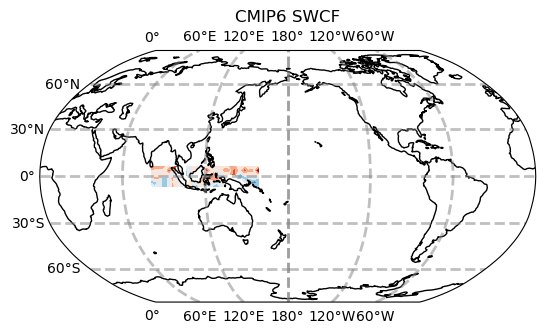

In [2]:
def global_plot(data, lon, lat, cmap, title=""):
    # plot map of global data with central longitude 180
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180))
    ax1.contourf(
        lon, lat, data,
        transform=ccrs.PlateCarree(), cmap=cmap
    )
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
    ax1.coastlines()
    ax1.set_global()
    ax1.set_title(title)
    plt.show()

    
swcf_cmip6 = xr.open_dataarray(f"data/swcf_cmip5_monthly_1850-2000.nc", chunks="auto").to_dataset(name="swcf")
swcf_cmip6 = xc.swap_lon_axis(swcf_cmip6, to=(-180, 180))
swcf_east = swcf_cmip6.sel(lon=slice(80, 160), lat=slice(-7, 7)).isel(model=14)

global_plot(lon=swcf_east.lon, lat=swcf_east.lat, data=swcf_east.swcf, cmap="RdBu_r", title="CMIP6 SWCF")
# swcf_cmip6.isel(model=1)

In [15]:
swcf_cmip6.close()

<xarray.DataArray 'lat' (lat: 72)>
array([-88.75, -86.25, -83.75, -81.25, -78.75, -76.25, -73.75, -71.25, -68.75,
       -66.25, -63.75, -61.25, -58.75, -56.25, -53.75, -51.25, -48.75, -46.25,
       -43.75, -41.25, -38.75, -36.25, -33.75, -31.25, -28.75, -26.25, -23.75,
       -21.25, -18.75, -16.25, -13.75, -11.25,  -8.75,  -6.25,  -3.75,  -1.25,
         1.25,   3.75,   6.25,   8.75,  11.25,  13.75,  16.25,  18.75,  21.25,
        23.75,  26.25,  28.75,  31.25,  33.75,  36.25,  38.75,  41.25,  43.75,
        46.25,  48.75,  51.25,  53.75,  56.25,  58.75,  61.25,  63.75,  66.25,
        68.75,  71.25,  73.75,  76.25,  78.75,  81.25,  83.75,  86.25,  88.75])
Coordinates:
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
Attributes:
    units:    degrees_north
    axis:     Y
    bounds:   lat_bnds


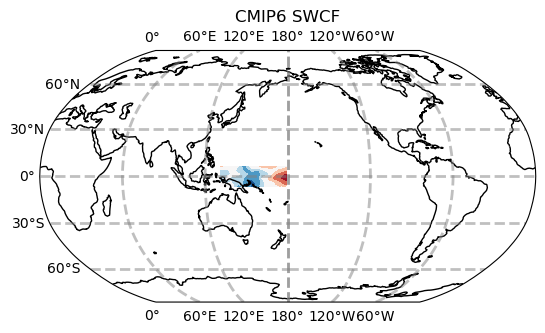

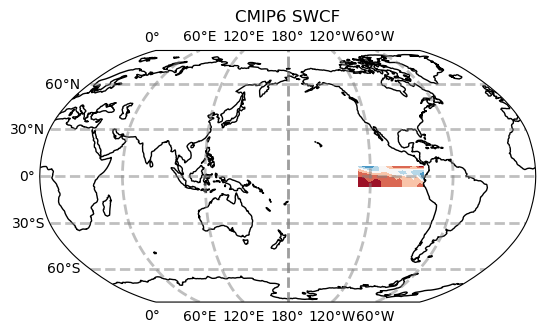

In [5]:
swcre_cmip6 = xr.open_dataset(f"data/swcre_cmip6_monthly_1850-2000.nc", chunks="auto") #.to_dataset(name="swcf")
swcre_cmip6 = xc.swap_lon_axis(swcre_cmip6, to=(-180, 180))
print(swcre_cmip6.lat)
# West pacific
swcre_west = swcre_cmip6.sel(lon=slice(130, 180), lat=slice(-7, 7)).isel(time=1,model=1)
# East pacific
swcre_east = swcre_cmip6.sel(lon=slice(-130, -80), lat=slice(-7, 7)).isel(time=1,model=1)

global_plot(lon=swcre_west.lon, lat=swcre_west.lat, data=swcre_west.swcre, cmap="RdBu_r", title="CMIP6 SWCF")
global_plot(lon=swcre_east.lon, lat=swcre_east.lat, data=swcre_east.swcre, cmap="RdBu_r", title="CMIP6 SWCF")